Scikit-learn HistGradientBoostingRegressor() model on MDA_dataframeArthur.csv.

Time Series cross-validation: 24h delay for weather, 1 month gap between train and test sets.
MAE en RMSE can be compared to other models.

In [11]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

Dataframe is loaded, 24h-delayed noise is added. Datetime columns are dropped in order to run model.

In [12]:
df = pd.read_csv("C:\\Users\Arthur\hello\\final_df.csv", delimiter=";")
df['result_timestamp'] = pd.to_datetime(df['result_timestamp'], format='%Y-%m-%d %H:%M:%S')
#select only three locations close to Oude Markt
df = df[df['object_id']<255442]
df

,object_id,result_timestamp,laeq,hour,day_of_week,month,weekend,holiday,exam_period,key,...,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0,LC_TEMP_QCL1,LC_TEMP_QCL2,LC_TEMP_QCL3
0,255441,2022-01-01 00:00:00,63.267554,0,5,1,True,True,False,2554412022-01-01 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,255441,2022-01-01 00:10:00,60.254000,0,5,1,True,True,False,2554412022-01-01 00:10:00,...,0.0,0.0,0.0,-48.0,0.04,0.0,13.28,13.28,13.223,13.23639
8,255441,2022-01-01 00:20:00,55.143907,0,5,1,True,True,False,2554412022-01-01 00:20:00,...,0.0,0.0,0.0,45.0,0.02,0.0,13.28,13.28,13.223,13.16699
12,255441,2022-01-01 00:30:00,58.230167,0,5,1,True,True,False,2554412022-01-01 00:30:00,...,0.0,0.0,0.0,-52.0,0.04,0.0,13.28,13.28,13.223,13.19886
16,255441,2022-01-01 00:40:00,54.220466,0,5,1,True,True,False,2554412022-01-01 00:40:00,...,0.0,0.0,0.0,34.0,0.02,0.0,13.28,13.28,13.223,13.16699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332425,255441,2022-12-31 23:10:00,53.712833,23,5,12,True,True,False,2554412022-12-31 23:10:00,...,0.0,0.0,0.0,-9.0,0.40,0.0,16.61,16.61,16.553,16.52797
332431,255441,2022-12-31 23:20:00,55.333167,23,5,12,True,True,False,2554412022-12-31 23:20:00,...,0.0,0.0,0.0,5.0,0.29,0.0,16.61,16.61,16.553,16.57995
332437,255441,2022-12-31 23:30:00,56.797333,23,5,12,True,True,False,2554412022-12-31 23:30:00,...,0.0,0.0,0.0,-17.0,0.15,0.0,16.51,16.51,16.453,16.44846
332443,255441,2022-12-31 23:40:00,61.010667,23,5,12,True,True,False,2554412022-12-31 23:40:00,...,0.0,0.0,0.0,-31.0,0.29,0.0,16.49,16.49,16.433,16.46641


In [13]:
#pipeline to create feature matrix with delayed noise and weather data, as well as target vector.

def delay_noise_weather(df):
    # Select columns for df_noisedelay
    df_noisedelay = df[['object_id', 'result_timestamp', 'laeq']]

    # Add 6 hours to result_timestamp
    df_noisedelay['result_timestamp'] += pd.DateOffset(hours=6)

    # Create key column
    df_noisedelay['key'] = df_noisedelay['object_id'].astype(str) + df_noisedelay['result_timestamp'].astype(str)

    # Drop unnecessary columns
    df_noisedelay = df_noisedelay.drop(['laeq', 'object_id', 'result_timestamp'], axis=1)

    # Select columns for df_weatherdelay
    df_weatherdelay = df[['object_id', 'result_timestamp', 'LC_HUMIDITY', 'LC_DWPTEMP', 'LC_n', 'LC_RAD', 'LC_RAININ',
                          'LC_DAILYRAIN', 'LC_WINDDIR', 'LC_WINDSPEED', 'LC_RAD60', 'LC_TEMP_QCL0']]

    # Add 6 hours to result_timestamp
    df_weatherdelay['result_timestamp'] += pd.DateOffset(hours=6)

    # Create key column
    df_weatherdelay['key'] = df_weatherdelay['object_id'].astype(str) + df_weatherdelay['result_timestamp'].astype(str)

    # Drop unnecessary columns
    df_weatherdelay = df_weatherdelay.drop(['object_id', 'result_timestamp'], axis=1)

    # Drop weather-related columns from original df
    df = df.drop(['LC_HUMIDITY', 'LC_DWPTEMP', 'LC_n', 'LC_RAD', 'LC_RAININ',
                  'LC_DAILYRAIN', 'LC_WINDDIR', 'LC_WINDSPEED', 'LC_RAD60', 'LC_TEMP_QCL0'], axis=1)

    # Merge df with df_noisedelay and df_weatherdelay on 'key'
    merged_df = pd.merge(df, df_noisedelay, on='key').merge(df_weatherdelay, on='key')

    # Delete observations with missing values
    merged_df = merged_df.dropna()

    # Create feature matrix X and target vector y
    X = merged_df.drop(['result_timestamp', 'laeq', 'key', 'object_id'], axis=1)
    y = merged_df['laeq']

    # Return feature matrix X and target vector y
    return X, y

#Apply to df
X, y = delay_noise_weather(df)

C:\Users\Arthur\AppData\Local\Temp\ipykernel_22164\717413586.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noisedelay['result_timestamp'] += pd.DateOffset(hours=6)
C:\Users\Arthur\AppData\Local\Temp\ipykernel_22164\717413586.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noisedelay['key'] = df_noisedelay['object_id'].astype(str) + df_noisedelay['result_timestamp'].astype(str)
C:\Users\Arthur\AppData\Local\Temp\ipykernel_22164\717413586.py:21: SettingWithCopyWarning: 
A value is trying to b

The target dataset (y) and predictor dataset (X) are created.

In [14]:
#create time-sensitive split for cross-validation: gap = 1 month, train size = 1/5 of data set, test size = max
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=12960,
    max_train_size=26300,
    test_size=18347,
)

In [15]:
#inspect splits
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]
X.iloc[test_0]
X.iloc[train_0]

,hour,day_of_week,month,weekend,holiday,exam_period,255439,255440,255441,255442,...,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0
1,6,5,1,True,True,False,False,False,True,False,...,91.0,11.88,38.0,0.0,0.0,0.0,-48.0,0.04,0.0,13.28
2,6,5,1,True,True,False,False,False,True,False,...,90.0,11.72,37.0,0.0,0.0,0.0,45.0,0.02,0.0,13.28
3,6,5,1,True,True,False,False,False,True,False,...,90.0,11.72,38.0,0.0,0.0,0.0,-52.0,0.04,0.0,13.28
4,6,5,1,True,True,False,False,False,True,False,...,90.0,11.72,37.0,0.0,0.0,0.0,34.0,0.02,0.0,13.28
5,6,5,1,True,True,False,False,False,True,False,...,90.0,11.72,38.0,0.0,0.0,0.0,0.0,0.00,0.0,13.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26167,0,0,4,False,True,False,False,True,False,False,...,41.0,-0.79,36.0,10.0,0.0,0.0,0.0,0.00,53.0,11.95
26168,0,0,4,False,True,False,False,False,True,False,...,41.0,-0.79,36.0,10.0,0.0,0.0,0.0,0.00,53.0,11.95
26169,0,0,4,False,True,False,True,False,False,False,...,42.0,-0.73,35.0,5.0,0.0,0.0,0.0,0.00,39.0,11.78
26170,0,0,4,False,True,False,False,True,False,False,...,42.0,-0.73,35.0,5.0,0.0,0.0,0.0,0.00,39.0,11.78


In [16]:
y

1         45.743000
2         48.452167
3         45.736167
4         44.955333
5         45.950833
            ...    
131013    53.712833
131014    55.333167
131015    56.797333
131016    61.010667
131017    58.354424
Name: laeq, Length: 130851, dtype: float64

In [17]:
train_4, test_4 = all_splits[4]
X.iloc[test_4]
X.iloc[train_4]

,hour,day_of_week,month,weekend,holiday,exam_period,255439,255440,255441,255442,...,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0
73278,10,4,7,False,True,False,False,False,True,False,...,71.0,10.73,32.0,9.0,0.0,0.000,33.0,0.02,0.0,15.89
73279,10,4,7,False,True,False,True,False,False,False,...,71.0,10.72,32.0,18.0,0.0,0.000,19.0,0.02,1.0,15.82
73280,10,4,7,False,True,False,False,True,False,False,...,71.0,10.72,32.0,18.0,0.0,0.000,19.0,0.02,1.0,15.82
73281,10,4,7,False,True,False,False,False,True,False,...,71.0,10.72,32.0,18.0,0.0,0.000,19.0,0.02,1.0,15.82
73282,11,4,7,False,True,False,True,False,False,False,...,72.0,10.70,32.0,26.0,0.0,0.000,24.0,0.01,2.0,15.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99624,10,2,9,False,False,False,False,False,True,False,...,97.0,7.89,31.0,0.0,0.0,0.003,0.0,0.00,0.0,8.28
99625,10,2,9,False,False,False,True,False,False,False,...,97.0,7.78,32.0,0.0,0.0,0.003,0.0,0.00,0.0,8.22
99626,10,2,9,False,False,False,False,True,False,False,...,97.0,7.78,32.0,0.0,0.0,0.003,0.0,0.00,0.0,8.22
99627,10,2,9,False,False,False,False,False,True,False,...,97.0,7.78,32.0,0.0,0.0,0.003,0.0,0.00,0.0,8.22


In [28]:
from sklearn.ensemble import HistGradientBoostingRegressor

# grid search for hyperparameter tuning
param_grid = {
    'learning_rate': (0.03,0.04,0.05),
    'max_leaf_nodes': (7,8,9)}
model = HistGradientBoostingRegressor()
scorer = "neg_mean_squared_error"
model_grid_search = GridSearchCV(model, param_grid=param_grid,
                                 n_jobs=2, cv=ts_cv, scoring=scorer)
model_grid_search.fit(X, y)


GridSearchCV(cv=TimeSeriesSplit(gap=12960, max_train_size=26300, n_splits=5, test_size=18347),
             estimator=HistGradientBoostingRegressor(), n_jobs=2,
             param_grid={'learning_rate': (0.03, 0.04, 0.05),
                         'max_leaf_nodes': (7, 8, 9)},
             scoring='neg_mean_squared_error')

In [29]:
accuracy = model_grid_search.score(X, y)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)

The test accuracy score of the grid-searched pipeline is: -9.28


In [30]:
model_grid_search.predict(X.iloc[0:5])

array([48.10098836, 48.10098836, 48.10098836, 48.10098836, 48.10098836])

In [31]:
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")

The best set of parameters is: {'learning_rate': 0.05, 'max_leaf_nodes': 8}


In [32]:
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_leaf_nodes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,1.026018,0.094761,0.089044,0.025221,0.05,8,"{'learning_rate': 0.05, 'max_leaf_nodes': 8}",-18.121762,-9.754790,-8.298531,-23.238703,-23.163281,-16.515413,6.406252,1
4,0.722827,0.067798,0.053960,0.001353,0.04,8,"{'learning_rate': 0.04, 'max_leaf_nodes': 8}",-18.251574,-10.414222,-8.445015,-24.145274,-22.143776,-16.679972,6.247046,2
6,0.808911,0.048103,0.075623,0.013333,0.05,7,"{'learning_rate': 0.05, 'max_leaf_nodes': 7}",-18.995970,-9.989873,-8.464550,-23.292361,-22.666507,-16.681852,6.279756,3
8,1.099893,0.102270,0.092012,0.033216,0.05,9,"{'learning_rate': 0.05, 'max_leaf_nodes': 9}",-18.732439,-9.724015,-8.134573,-23.052067,-23.775059,-16.683631,6.581270,4
5,0.764986,0.053492,0.074910,0.016846,0.04,9,"{'learning_rate': 0.04, 'max_leaf_nodes': 9}",-18.757733,-10.128245,-8.295699,-23.961904,-22.897966,-16.808309,6.467548,5


In [33]:
# get the parameter names
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

In [34]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,param_learning_rate,param_max_leaf_nodes,mean_test_score,std_test_score,rank_test_score
7,0.05,8,-16.515413,6.406252,1
4,0.04,8,-16.679972,6.247046,2
6,0.05,7,-16.681852,6.279756,3
8,0.05,9,-16.683631,6.581270,4
5,0.04,9,-16.808309,6.467548,5
3,0.04,7,-17.053557,6.383796,6
2,0.03,9,-17.203753,6.496744,7
0,0.03,7,-17.283513,6.136932,8
1,0.03,8,-17.411856,6.341358,9


In [35]:
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score", index=["param_learning_rate"],
    columns=["param_max_leaf_nodes"])

pivoted_cv_results

param_max_leaf_nodes,7,8,9
param_learning_rate,,,
0.03,-17.283513,-17.411856,-17.203753
0.04,-17.053557,-16.679972,-16.808309
0.05,-16.681852,-16.515413,-16.683631


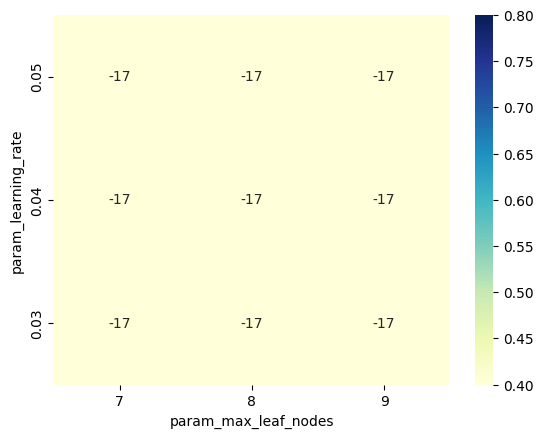

In [36]:
import seaborn as sns

ax = sns.heatmap(pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.4,
                 vmax=0.8)
ax.invert_yaxis()

Mean Absolute Error:     2.859 +/- 0.564
Root Mean Squared Error: 4.050 +/- 0.877


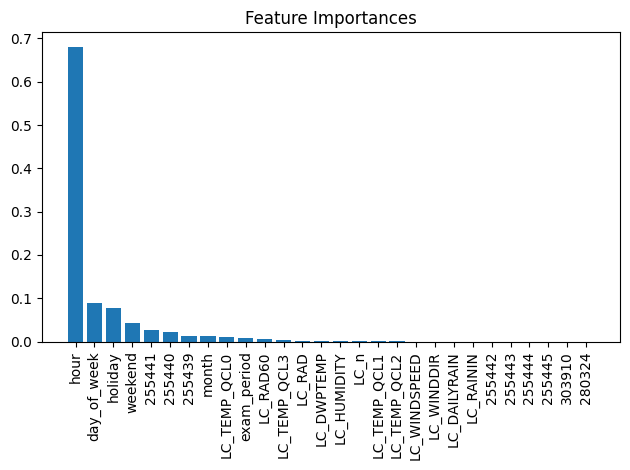

In [37]:
#run gradient boosting model and plot feature importances
import numpy as np
import matplotlib.pyplot as plt

def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

    # Fit the model on the data
    model.fit(X, y)

    # Retrieve feature importances
    feature_importances = model.named_steps['gradientboostingregressor'].feature_importances_
    feature_names = X.columns

    # Sort feature importances in descending order
    indices = np.argsort(feature_importances)[::-1]

    # Plot feature importances
    plt.figure()
    plt.title('Feature Importances')
    plt.bar(range(X.shape[1]), feature_importances[indices], align='center')
    plt.xticks(range(X.shape[1]), feature_names[indices], rotation='vertical')
    plt.tight_layout()
    plt.show()

gbrt_pipeline = make_pipeline(GradientBoostingRegressor(max_leaf_nodes=8, learning_rate=0.05))
evaluate(gbrt_pipeline, X, y, cv=ts_cv)


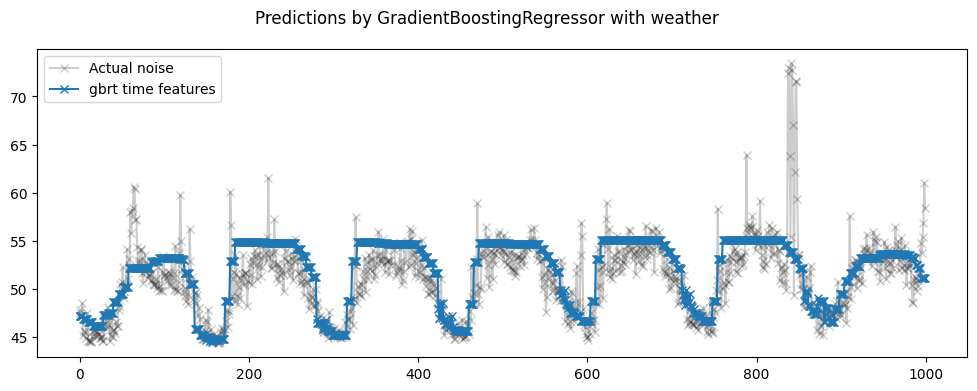

In [50]:
#Qualitative analysis of the impact of features on linear model predictions
gbrt_pipeline.fit(X, y)
gbrt_predictions = gbrt_pipeline.predict(X)

last_hours = slice(-1000, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by GradientBoostingRegressor with weather")
ax.plot(
    y.values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual noise",
    color="black",
)
ax.plot(gbrt_predictions[last_hours], "x-", label="gbrt time features")
_ = ax.legend()


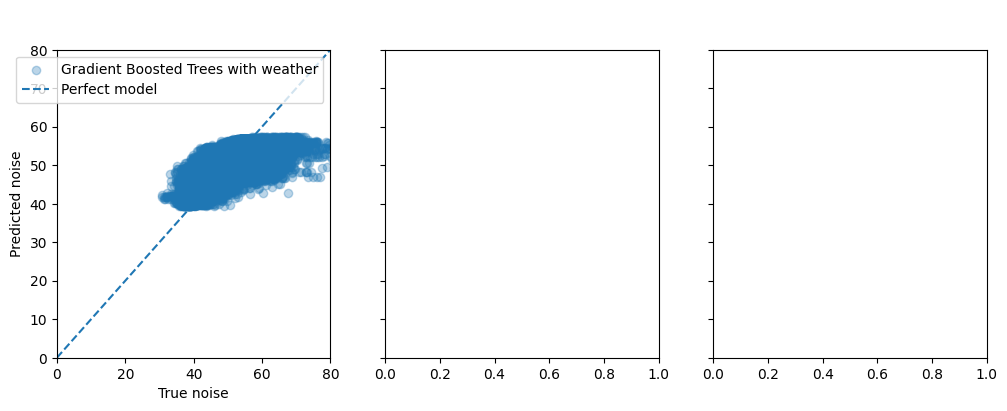

In [51]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
fig.suptitle(" ")
predictions = [
    gbrt_predictions,
]
labels = [
    "Gradient Boosted Trees with weather",
]
for ax, pred, label in zip(axes, predictions, labels):
    ax.scatter(y.values, pred, alpha=0.3, label=label)
    ax.plot([0, 80], [0, 80], "--", label="Perfect model")
    ax.set(
        xlim=(0, 80),
        ylim=(0, 80),
        xlabel="True noise",
        ylabel="Predicted noise",
    )
    ax.legend()

plt.show()

In [52]:
#predict nighttime values only
df_night = df.set_index('result_timestamp')

In [53]:
df_night = df_night.between_time(start_time='22:00:00', end_time='6:00:00', inclusive='left')
df_night = df_night.reset_index()
df_nd_n = df_night.drop(['key','object_id','result_timestamp','date','time','day_time','day_hour','LC_TEMP_QCL1','LC_TEMP_QCL2','LC_TEMP_QCL3'], axis=1)

In [54]:
df_nd_n = df_nd_n[df_nd_n.isna()['LC_HUMIDITY']==False]
df_nd_n.isna().sum()

laeq            0
hour            0
weekday         0
month           0
weekend         0
holiday         0
exam_period     0
255439          0
255440          0
255441          0
laeq_delayed    0
LC_HUMIDITY     0
LC_DWPTEMP      0
LC_n            0
LC_RAD          0
LC_RAININ       0
LC_DAILYRAIN    0
LC_WINDDIR      0
LC_WINDSPEED    0
LC_RAD60        0
LC_TEMP_QCL0    0
dtype: int64

In [55]:
df_nd_n['weekday'] = df_nd_n['weekday'].replace(to_replace='Monday', value=0)
df_nd_n['weekday'] = df_nd_n['weekday'].replace(to_replace='Tuesday', value=1)
df_nd_n['weekday'] = df_nd_n['weekday'].replace(to_replace='Wednesday', value=2)
df_nd_n['weekday'] = df_nd_n['weekday'].replace(to_replace='Thursday', value=3)
df_nd_n['weekday'] = df_nd_n['weekday'].replace(to_replace='Friday', value=4)
df_nd_n['weekday'] = df_nd_n['weekday'].replace(to_replace='Saturday', value=5)
df_nd_n['weekday'] = df_nd_n['weekday'].replace(to_replace='Sunday', value=6)

In [56]:
y_night = df_nd_n["laeq"]
X_night = df_nd_n.drop("laeq", axis="columns")

In [57]:
predictions = gbrt_pipeline.predict(X_night)
predictions

array([52.92508254, 52.92508254, 52.92508254, ..., 51.16399268,
       51.16399268, 51.16399268])

In [58]:
MAE = sum(((predictions-y_night)**2)**(1/2))/len(y_night)
MAE

2.8182937993204478

In [59]:
RMSE = (sum((predictions-y_night)**2)/len(y_night))**(1/2)
RMSE

3.9318577718723073